Copying the data from zip file to a different location. Mainly because the input directory given by Kaggle is a read-only folder.

In [1]:
! mkdir ../data
! mkdir ../data/train
! mkdir ../data/validation
! cp -r ../input/training/training/* ../data/train/
! cp -r ../input/validation/validation/* ../data/validation/

Import statements

In [2]:
from fastai import *
from fastai.vision import *
from pathlib import Path

Loading the data

In [3]:
data = ImageDataBunch.from_folder(path=Path('../data').resolve(), train='train', valid='validation', dl_tfms=get_transforms(), num_workers=0, bs=64, size=224).normalize(imagenet_stats)

In [4]:
# import pandas as pd

# labels_df = pd.read_csv('../input/monkey_labels.txt', delimiter=' *, *', engine='python')
# labels = dict(zip(labels_df['Label'].tolist(), labels_df['Common Name'].tolist()))

In [5]:
# data = ImageImageList.from_folder(path=Path('../data').resolve()).split_by_folder(train='train', valid='validation').label_from_func(func=lambda x: labels[str(x.parts[-2])]).transform(get_transforms(), size=224).databunch(num_workers=0, bs=64).normalize(imagenet_stats)

Visualizing some of the data loaded

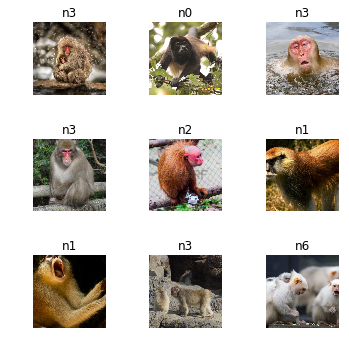

In [6]:
data.show_batch(rows=3, figsize=(5,5))

Creating a ResNet34 based CNN classifier and fitting for 3 cycles

In [7]:
learn_34 = create_cnn(data, models.resnet34, metrics=[accuracy, error_rate])
learn_34.fit_one_cycle(3)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 53820450.84it/s]


epoch,train_loss,valid_loss,accuracy,error_rate,time
1,1.433131,0.097822,0.996324,0.003676,01:31
2,0.654193,0.044775,0.992647,0.007353,01:28
3,0.382647,0.046213,0.992647,0.007353,01:28


Creating a plot to check the predictions

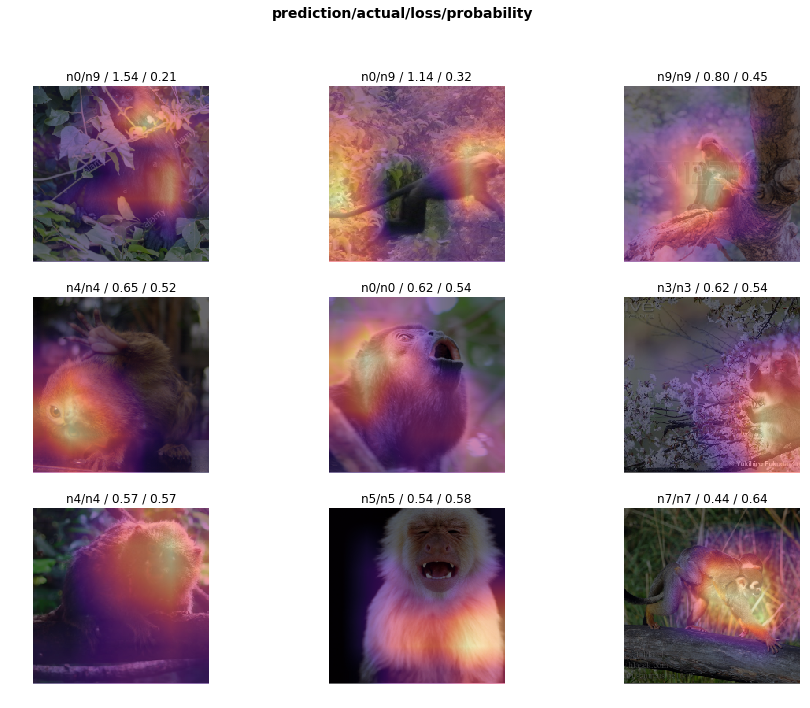

In [8]:
interp_34 = ClassificationInterpretation.from_learner(learn_34)
interp_34.plot_top_losses(9, figsize=(15,11))

We can see that the classifier misclassifies to 3 images from the validation set. We can also observe that the model has learnt that the face of the monkey is the most important feature to classify the breed.

Let us check out the confusion matrix to see where the wrong classifications are happening

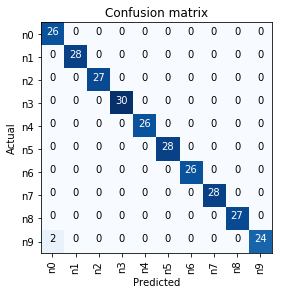

In [9]:
interp_34.plot_confusion_matrix()

Using Learning Rate finder to find the LR sweet spot to improve the model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


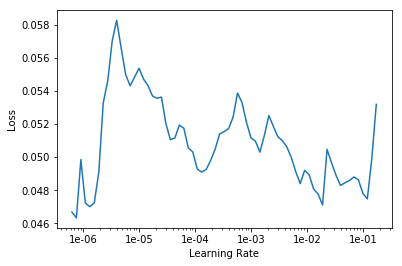

In [10]:
learn_34.lr_find()
learn_34.recorder.plot()

The learning rate between 2e-4 and 9e-2 has the longest slope of decreasing loss. Using that range to train the network further

In [11]:
learn_34.fit_one_cycle(1, slice(2e-4, 9e-2))

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,0.141415,0.043310,0.981618,0.018382,01:28


The validation loss and the accuracy has saturated for the model based on ResNet34. Trying a larger model.

In [12]:
learn_50 = create_cnn(data, models.resnet50, metrics=[accuracy, error_rate])
learn_50.fit_one_cycle(3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 84959428.14it/s]


epoch,train_loss,valid_loss,accuracy,error_rate,time
1,0.838872,0.033875,0.996324,0.003676,01:49
2,0.372514,0.017252,0.996324,0.003676,01:39
3,0.212350,0.017284,0.996324,0.003676,01:39


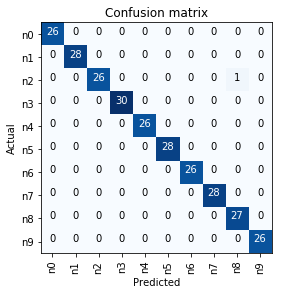

In [13]:
interp_50 = ClassificationInterpretation.from_learner(learn_50)
interp_50.plot_confusion_matrix()

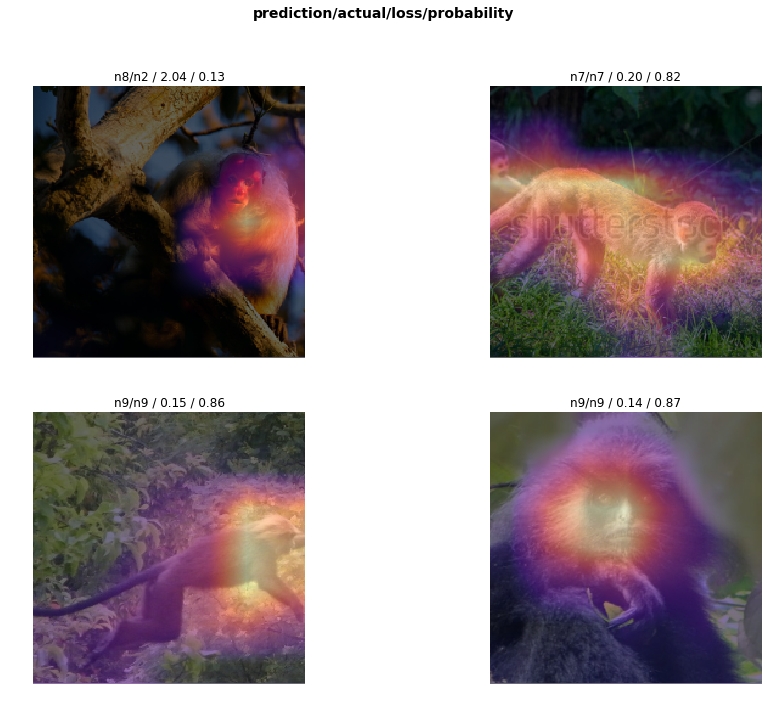

In [14]:
interp_50.plot_top_losses(4, figsize=(15,11))

Just one image is being predicted wrong. And we can see the probability of this prediction is very low compared to the others.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


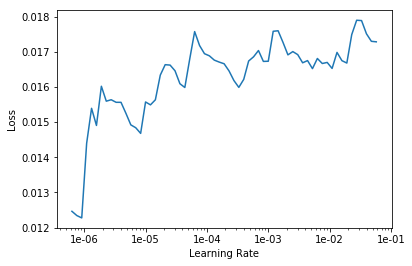

In [15]:
learn_50.lr_find()
learn_50.recorder.plot()

In [16]:
learn_50.fit_one_cycle(2, slice(8e-06, 1.2e-06))

epoch,train_loss,valid_loss,accuracy,error_rate,time
1,0.015695,0.018056,0.996324,0.003676,01:38
2,0.017086,0.016782,0.996324,0.003676,01:36


Looks like we are able to get close 100% accuracy. Just 1 mistake by the model. For a model trained in under 10 minutes, an accuracy of this level is astounding. With a little more tweaks, we should be able to get 100% accuracy.

EDIT: I was able to get 100% by running the kernel over and over a couple of times. I guess the randomness helps boost this accuracy. But since Kaggle runs the kernel again when making the commit, the results will be slightly different.